In [9]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

filename = "datasets/original_dataset.xlsx"
df = pd.read_excel(filename, engine='openpyxl')

df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,NaN,338.0,NaN,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [10]:
# data type & selecting feature(baseline model only used long-history feature)
numeric_features = ['Long_1', 'Long_2', 'Long_3', 'Long_4', 'Long_5', 'Long_6',
                    'Long_7', 'Long_8', 'Long_9', 'Long_10']

# using linear imputation 
for feature in numeric_features:
    # create a imputation function
    interpolator = interp1d(df['submission_year'], df[feature], kind='linear', fill_value='extrapolate')
    
    # fill in NA，transforming the outcome to Series
    interpolated_values = pd.Series(interpolator(df['submission_year']), name=feature)
    
    # using fillna method to fill into NA
    df[feature].fillna(interpolated_values, inplace=True)

df


c:\Users\yanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\yanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\yanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,0.0,338.0,3.0,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [11]:
# Separate data into training and validation sets
train_df = df[df['TrainVal'] == 'Train_60']
val_df = df[df['TrainVal'] == 'Val_40']

# Separate features and target variable
X_train = train_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                 'Short_1','Short_2','Short_3','Short_4','Short_5','Short_6',
                                 'Short_7','Short_8','Short_9', 'Short_10'])
y_train = train_df['target']

X_val = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                             'Short_1','Short_2','Short_3','Short_4','Short_5',
                             'Short_6','Short_7','Short_8','Short_9', 'Short_10'])
y_val = val_df['target']

In [12]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01,0.02,0.025],
    'max_depth': [3, 4,5],
    'n_estimators': [90,100,110],
    'subsample': [0.4,0.5,0.6],
    'colsample_bytree': [0.85,0.89,0.9],
}
clf = xgb.XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(grid_search.best_params_)

best_clf = grid_search.best_estimator_


# Predict using the best model
# y_pred = best_clf.predict(X_val_new)



Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.5}


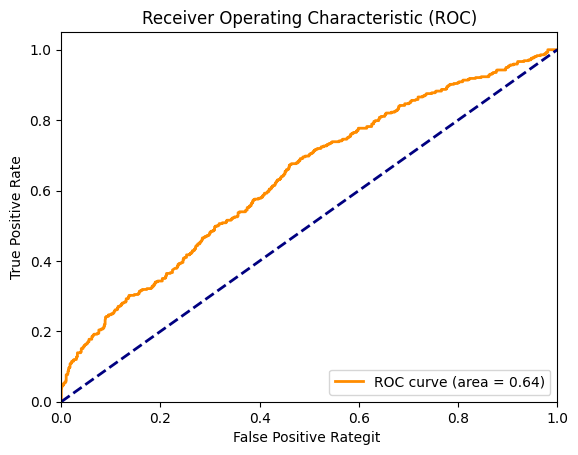

In [13]:
# AUC
from sklearn.metrics import roc_curve, auc

# best_clf.fit(X_train_new, y_train)

# Predict on validation set
y_pred = best_clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rategit ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('./images/baseline_result.jpg')

plt.show()

In [14]:
# Calculate Gini coefficient
gini_coefficient = 2 * roc_auc - 1
print("Gini Coefficient: ", gini_coefficient)


Gini Coefficient:  0.27386803428544315


In [15]:
# Calculate numbers of features
num_features = X_train.shape[1]
print("Number of Features: ", num_features)

Number of Features:  10


In [18]:
# Retrieve the best model (after hyperparameter tuning)
best_clf = grid_search.best_estimator_

# Get and sort feature importances
feature_importances = pd.Series(best_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Print the top 5 most important features
print("Top 5 Features:\n", feature_importances.head(5))


Top 5 Features:
 Long_6    0.190177
Long_7    0.129938
Long_2    0.118879
Long_8    0.092771
Long_3    0.091351
dtype: float32
